<a href="https://colab.research.google.com/github/Talendar/facial_expression_detection/blob/main/facial_expression_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of facial expressions on the QIDER dataset

to_do: introduction

### Installing and importing dependencies

In [ ]:
!pip install py7zr
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

### Loading the dataset and auxiliary functions from GitHub:

In [ ]:
!git clone https://github.com/Talendar/facial_expression_detection
%cd facial_expression_detection
from utils import *

### Loading data

In [5]:
train_data, train_labels = load_qider("./data/QIDER/train", (128, 128))
val_data, val_labels = load_qider("./data/QIDER/val", (128, 128))

print("  [TRAINING] DATA SHAPE: {}  |  LABELS SHAPE:  {}".format(train_data.shape, train_labels.shape))
print("[VALIDATION] DATA SHAPE: {}  |  LABELS SHAPE:  {}".format(val_data.shape, val_labels.shape))

  [TRAINING] DATA SHAPE: (2910, 128, 128, 1)  |  LABELS SHAPE:  (2910,)
[VALIDATION] DATA SHAPE: (1000, 128, 128, 1)  |  LABELS SHAPE:  (1000,)


### Exploring data

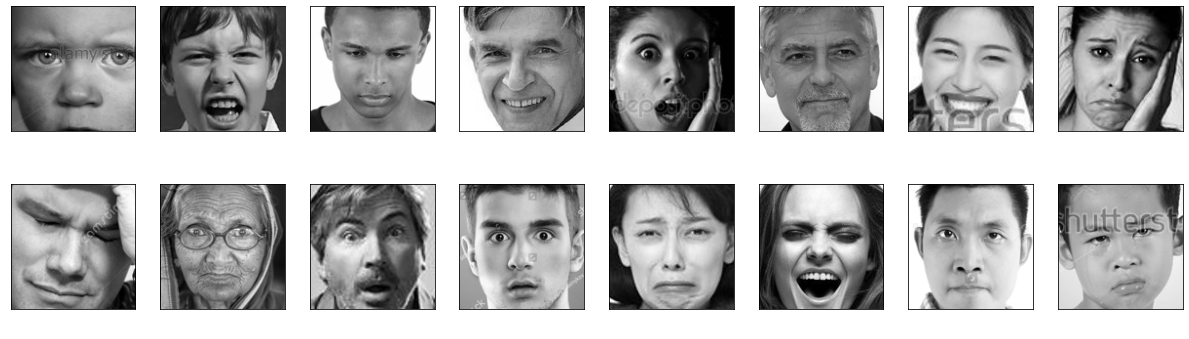

In [6]:
plt.figure(figsize=(21, 6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    img = randimg(train_data, train_labels)
    plt.imshow(img[0].reshape(img[0].shape[0], img[0].shape[1]), "gray")
    plt.xlabel(img[1], fontsize=20).set_color("white")
plt.show()

### Data augmentation

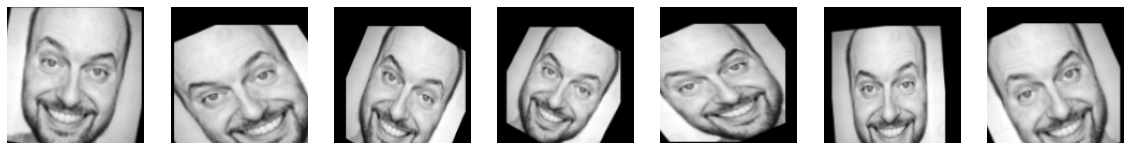

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", dtype="float32"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, fill_mode="constant"),
  tf.keras.layers.experimental.preprocessing.RandomZoom(.25, .25, fill_mode="constant"),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.15, 0.15, fill_mode="constant"),
])

# sample
idx = np.random.randint(0, len(train_data))
plt.figure(figsize=(20, 7))
for i in range(7):
    img = data_augmentation(tf.expand_dims(train_data[idx], 0))[0]
    ax = plt.subplot(1, 7, i + 1)
    plt.imshow(tf.reshape(img, (img.shape[0], img.shape[1])), "gray")
    plt.axis("off")

### Building and training model

In [18]:
tf.keras.backend.clear_session()
cnn_model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding="valid", activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation='relu'),
    #tf.keras.layers.MaxPool2D((2, 2)),
    #tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(EXPRESSIONS), activation="softmax")
])

cnn_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=["accuracy"])

hist = cnn_model.fit(train_data, train_labels, epochs=250,
              validation_data=(val_data, val_labels), 
              callbacks=[ClearCallback(), EarlyStopping(monitor='val_loss', patience=15)]);

val_loss, val_acc = cnn_model.evaluate(val_data,  val_labels, verbose=2)
print('\nTraining accuracy: %.2f%%' % (hist.history["accuracy"][-1] * 100))
print('Validation accuracy: %.2f%%' % (val_acc * 100))

91/91 [==============================] - 6s 62ms/step - loss: 1.9064 - accuracy: 0.2265 - val_loss: 1.8986 - val_accuracy: 0.2180
Epoch 4/250
65/91 [====================>.........] - ETA: 1s - loss: 1.8889 - accuracy: 0.2630

KeyboardInterrupt: ignored